In [1]:
import pandas as pd
import torch
import json
import os
import argparse
import random
import pickle
import numpy as np
from collections import defaultdict
from operator import itemgetter
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import gzip
from pprint import pprint
from scipy.stats import ttest_ind
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import KMeans
from sklearn import manifold


import data
import data_config

import warnings
warnings.filterwarnings("ignore")

/Users/hedi/.conda/envs/pytorch/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.bicluster module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


In [3]:
def reverse_rankdata(a):
    return rankdata([-1 * i for i in a]).astype(int)

def generate_p_val(a, b):
    t, p = ttest_ind(a, b, equal_var=False)
    print("ttest_ind:            t = %g  p = %g" % (t, p))

## Ablation Study 

In [4]:
def build_ablation_plot_df(mean_val_df, drug_list, pdtc_flag=False, by='adsn_norm'):
    method_dict = {
               'ndsn':"code-ae-base*", 
               'mdsn': 'code-ae-mmd*', 
               'adsn': 'code-ae-adv*',
               'ndsn_concat':"code-ae-base(concat)*", 
               'mdsn_concat': 'code-ae-mmd(concat)*', 
               'adsn_concat': 'code-ae-adv(concat)*',
               'ndsn_norm_concat':"code-ae-base(concat)", 
               'mdsn_norm_concat': 'code-ae-mmd(concat)', 
               'adsn_norm_concat': 'code-ae-adv(concat)',
               'ndsn_norm':"code-ae-base", 
               'mdsn_norm': 'code-ae-mmd', 
               'adsn_norm': 'code-ae-adv'
              }
    if pdtc_flag:
        drug_mapping_df = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0)
    else:
        drug_mapping_df = pd.read_csv(data_config.gdsc_tcga_mapping_file, index_col=0)
        
    drug_dict = drug_mapping_df['gdsc_name'].to_dict()
    
    mean_val_df = mean_val_df[drug_list]
    drug_order = mean_val_df.transpose().sort_values(by, ascending=False).index.to_list()
    drug_order = [drug_dict[drug] for drug in drug_order]
    
    mean_val_df = mean_val_df.rename(index=method_dict)
    mean_val_df = mean_val_df.rename(index={k: k.upper() for k in mean_val_df.index})
    mean_val_df = mean_val_df.rename(columns=drug_dict)
    mean_val_df = mean_val_df.stack().rename('mean_val')
        
    plot_df = mean_val_df.to_frame().reset_index().rename(columns={'level_0':'method', 'level_1':'drug'})
    plot_df['normalization'] = ['NO' if flag else 'YES' for flag in plot_df.method.str.contains('\*')]
    plot_df.loc[plot_df.normalization == 'NO', 'method'] = plot_df.loc[plot_df.normalization == 'NO', 'method'].str[:-1]

            
    method_order = ['CODE-AE-ADV','CODE-AE-ADV(CONCAT)', 'CODE-AE-BASE','CODE-AE-BASE(CONCAT)','CODE-AE-MMD','CODE-AE-MMD(CONCAT)']
    plot_df.method = plot_df.method.astype('category')
    plot_df.method.cat.set_categories(method_order, inplace=True)
    plot_df.sort_values(by='method', inplace=True)
    
    plot_df.drug = plot_df.drug.astype('category')
    plot_df.drug.cat.set_categories(drug_order, inplace=True)
    plot_df.sort_values(by='drug', inplace=True)


    
    return plot_df

    

In [5]:
pdtc_drug_list = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0).index.tolist()
pdtc_auc_ft_report = pd.read_csv('../intermediate_results/plot_data/ablation_pdtc_auc_ft_mean.csv', index_col=0)
pdtc_auc_ft_report_std = pd.read_csv('../intermediate_results/plot_data/ablation_pdtc_auc_ft_std.csv',index_col=0)
ablation_pdtc_plot_df = build_ablation_plot_df(mean_val_df=pdtc_auc_ft_report,
                             drug_list = pdtc_drug_list,
                             pdtc_flag=True,
                             by='adsn_norm'
)

In [6]:
pdtc_auc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)

method
ndsn                9.02
mdsn                6.32
adsn                3.80
ndsn_norm           6.34
mdsn_norm           7.08
adsn_norm           1.70
ndsn_concat         9.20
mdsn_concat         6.90
adsn_concat         4.40
ndsn_norm_concat    7.52
mdsn_norm_concat    8.70
adsn_norm_concat    6.50
dtype: float64

In [7]:
pdtc_auc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)

method
ndsn                2.217647
mdsn                2.645288
adsn                2.222336
ndsn_norm           3.255200
mdsn_norm           3.911469
adsn_norm           1.265718
ndsn_concat         2.515260
mdsn_concat         2.501020
adsn_concat         2.579353
ndsn_norm_concat    3.418079
mdsn_norm_concat    2.620562
adsn_norm_concat    2.764572
dtype: float64

In [8]:
palette ={
    'CODE-AE-BASE':'yellow', 
    'CODE-AE-MMD':'blue',
    'CODE-AE-ADV':'red',
    'CODE-AE-BASE(CONCAT)':'green', 
    'CODE-AE-MMD(CONCAT)':'purple',
    'CODE-AE-ADV(CONCAT)':'black'}

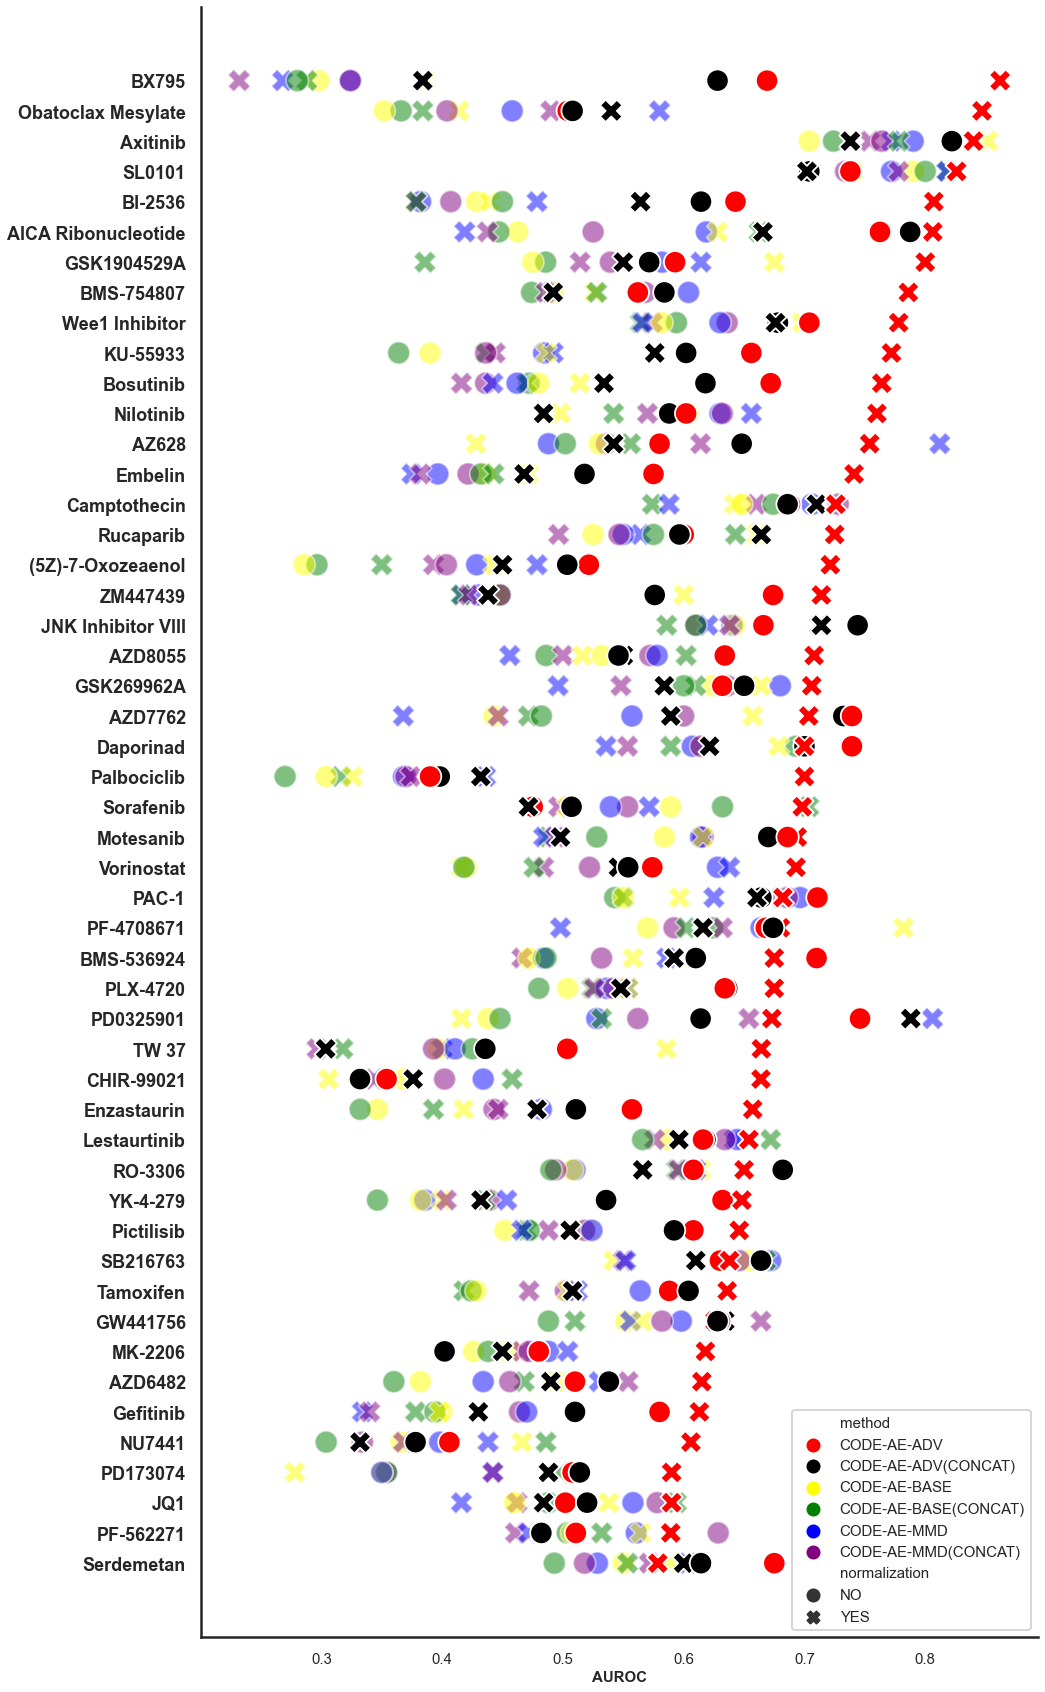

In [9]:
plt.figure(figsize=(15, 30))
sns.set(style='white', context='poster')
ax = sns.scatterplot(x='mean_val', y='drug', hue='method', style='normalization',
                     alpha=0.5,
                     s=500,
                     palette=palette,
                     data=ablation_pdtc_plot_df[ablation_pdtc_plot_df.method.isin(['CODE-AE-MMD','CODE-AE-BASE','CODE-AE-BASE(CONCAT)','CODE-AE-MMD(CONCAT)'])],
                    legend=False)
sns.scatterplot(x='mean_val', y='drug', hue='method', style='normalization',
                alpha=1.0,
                s=500,
                palette=palette,
                data=ablation_pdtc_plot_df[ablation_pdtc_plot_df.method.str.contains('CODE-AE-ADV')]
               )

sns.despine()
plt.ylabel('')
plt.xlabel('AUROC', fontsize=15, weight='bold')
plt.yticks(fontsize=18, weight='bold')
plt.xticks(fontsize=15)
plt.legend(loc='lower right', fontsize=15)
#plt.savefig('../paper/ablation_pdtc_auc.png', format='png', dpi=350,bbox_inches='tight')

## PDTC study result

In [10]:
def build_plot_df(mean_val_df, std_val_df, drug_list, pdtc_flag=False, by='adsn_norm'):
    method_dict = {'tcrp': 'tcrp',
                   'cell_enet':'celligner',
               'dsn':"dsn-mmd", 
               'dsna': 'dsn-dann', 
               'adsn_norm': 'code-ae-adv'
              }

    if pdtc_flag:
        drug_mapping_df = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0)
    else:
        drug_mapping_df = pd.read_csv(data_config.gdsc_tcga_mapping_file, index_col=0)
        
    drug_dict = drug_mapping_df['gdsc_name'].to_dict()
    
    mean_val_df = mean_val_df[drug_list]
    drug_order = mean_val_df.transpose().sort_values(by, ascending=False).index.to_list()
    drug_order = [drug_dict[drug] for drug in drug_order]
    
    mean_val_df = mean_val_df.rename(index=method_dict)
    mean_val_df = mean_val_df.rename(index={k: k.upper() for k in mean_val_df.index})
    mean_val_df = mean_val_df.rename(columns=drug_dict)
    mean_val_df = mean_val_df.stack().rename('mean_val')
    
    std_val_df = std_val_df[drug_list].rename(index=method_dict)
    std_val_df = std_val_df.rename(index={k: k.upper() for k in std_val_df.index})
    std_val_df = std_val_df.rename(columns=drug_dict)
    std_val_df = std_val_df.stack().rename('s.d.')
    std_val_df = pd.cut(std_val_df,
       [0,0.01,0.10,1.0], 
       labels=["<0.01", "0.01-0.10",'>0.10'],
       include_lowest=True,
      )
    std_val_df = std_val_df.cat.set_categories(reversed(std_val_df.cat.categories))
    
    plot_df = mean_val_df.to_frame().join(std_val_df).reset_index().rename(columns={'level_0':'method', 'level_1':'drug'})
    
    plot_df.drug = plot_df.drug.astype('category')
    plot_df.drug.cat.set_categories(drug_order, inplace=True)
    plot_df.sort_values(by='drug', inplace=True)
    
    method_order = ['RF','ENET', 'MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN', 'COXRF','CELLIGNER','ADAE',"VELODROME",'CODE-AE-ADV']
    plot_df.method = plot_df.method.astype('category')
    plot_df.method.cat.set_categories(method_order, inplace=True)
    plot_df.sort_values(by='method', inplace=True)
    
    plot_df['pre_training'] = 'YES'
    plot_df.loc[plot_df.method.isin(['RF', 'ENET','MLP','TCRP']), 'pre_training']='NO'

    
    return plot_df

    

In [11]:
pdtc_auc_ft_report = pd.read_csv('../intermediate_results/plot_data/pdtc_auc_ft_mean.csv', index_col=0)
pdtc_auc_ft_report_std = pd.read_csv('../intermediate_results/plot_data/pdtc_auc_ft_std.csv',index_col=0)
pdtc_plot_df = build_plot_df(mean_val_df=pdtc_auc_ft_report,
                             std_val_df=pdtc_auc_ft_report_std,
                             drug_list = pdtc_drug_list,
                             pdtc_flag=True,
                             by='adsn_norm'
)

In [12]:
pdtc_auc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)

method
cell_enet    12.38
enet         13.86
rf           14.66
mlp          14.54
ae            9.94
dae           9.94
vae           4.52
vaen          6.78
coral         9.10
adae          4.30
tcrp         12.66
dsna          8.04
coxen         8.08
coxerf        7.92
velodrome     7.56
dsn           6.14
adsn_norm     2.20
dtype: float64

In [13]:
pdtc_auc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)

method
cell_enet    4.065233
enet         2.969299
rf           2.143905
mlp          2.205836
ae           3.448809
dae          2.909590
vae          2.771870
vaen         3.072525
coral        3.045572
adae         2.062790
tcrp         3.133818
dsna         2.820913
coxen        5.502652
coxerf       5.259937
velodrome    3.954641
dsn          3.574342
adsn_norm    1.484615
dtype: float64

In [14]:
palette ={
    'ENET':'mediumpurple', 
    'RF':'rebeccapurple',
    'MLP':'purple', 
    'AE':'palegreen',
    'DAE':'limegreen',
    'VAE':'seagreen',
    'VAEN': 'darkgreen',
    'CORAL':'orange',
    'ADAE':'blue', 
    'COXEN':'lightgray',
    'COXRF':'darkgray',
    'CELLIGNER':'darkslategray',
    'DSN-MMD':'gold',
    'DSN-DANN':'yellow', 
    'TCRP':'black',
    "VELODROME":"pink",
    'CODE-AE-ADV':'red'}

marker_dict = {
    'ENET':'s', 
    'RF':'s',
    'MLP':'s', 
    'AE':'P',
    'DAE':'P',
    'VAE':'P',
    'VAEN': 'P',
    'CORAL':'H',
    'ADAE':'H', 
    'COXEN':'X',
    'COXRF':'X',
    'CELLIGNER':'X',
    "VELODROME":"H",
    'DSN-MMD':'D',
    'DSN-DANN':'D', 
    'TCRP':'s',
    'CODE-AE-ADV':'o'
}

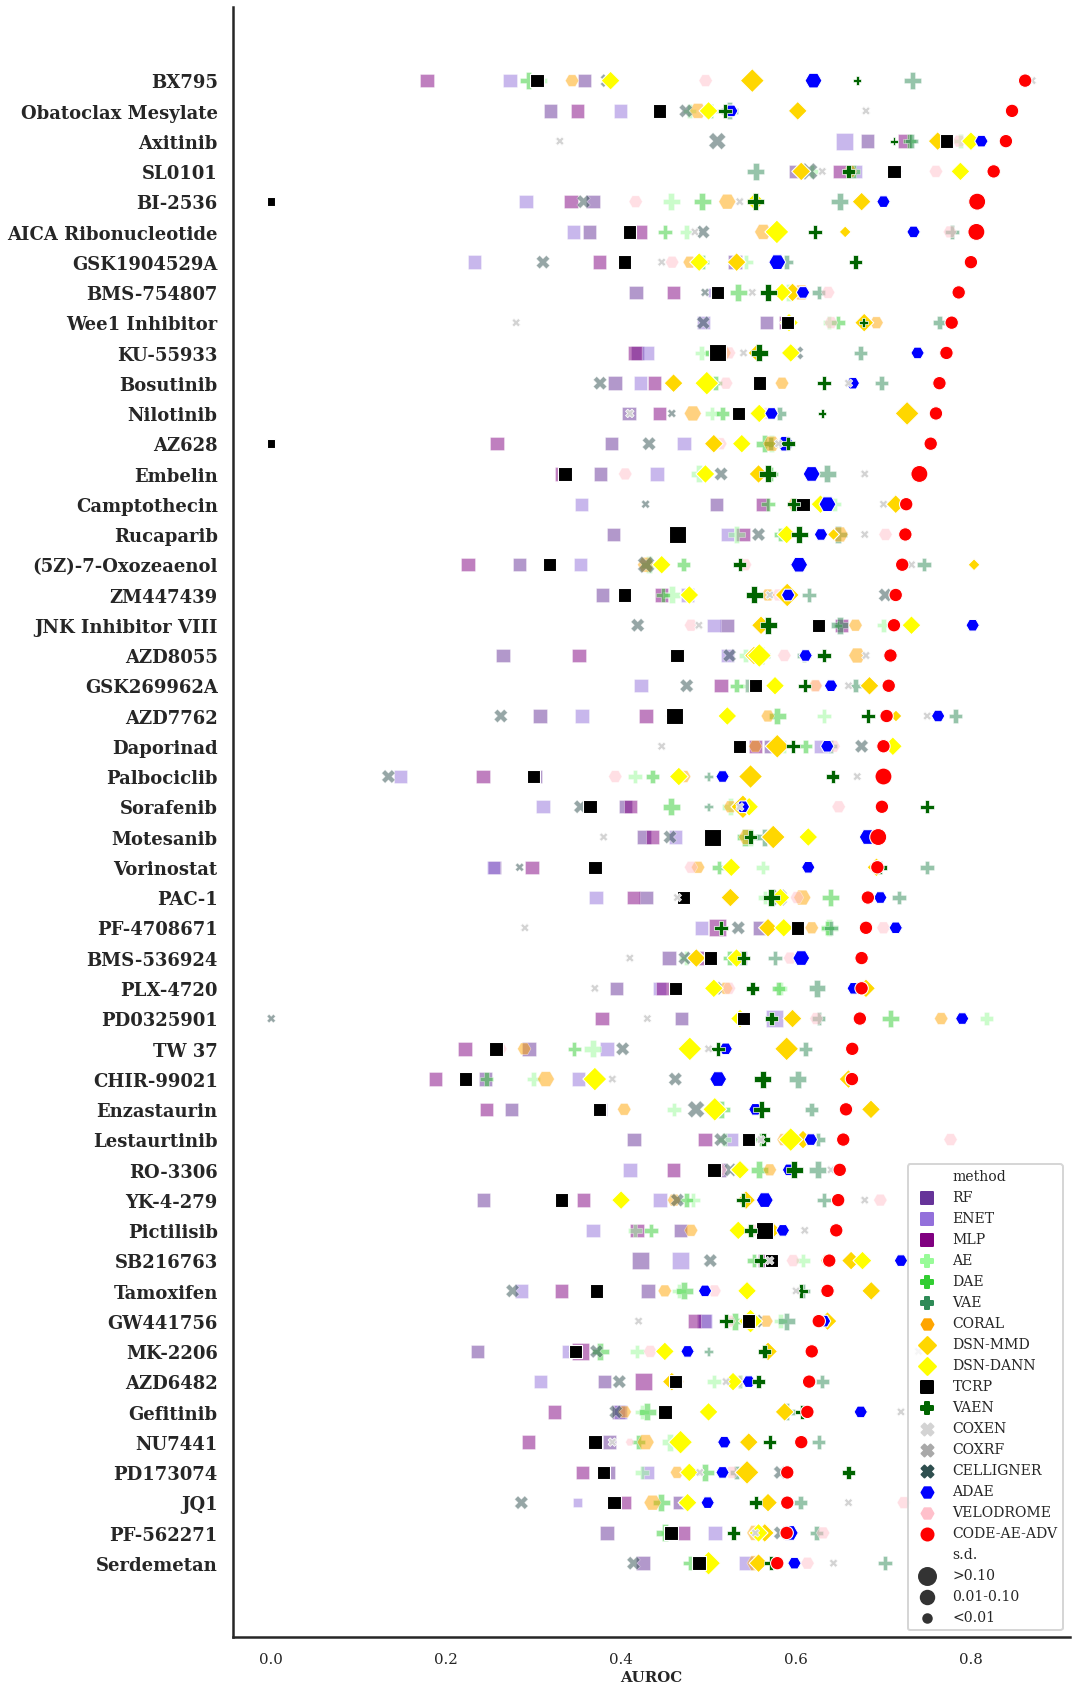

In [15]:
plt.figure(figsize=(15, 30))
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})
ax = sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                     alpha=0.5,
                     s=500,
                     palette=palette,
                     data=pdtc_plot_df[~pdtc_plot_df.method.isin(['CODE-AE-ADV', 'TCRP','VAEN','DSN-MMD','DSN-DANN','ADAE'])],
                    legend=True)
sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['DSN-MMD','DSN-DANN','ADAE'])],
                legend=False
               )

sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.', style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['TCRP'])],
                legend=False
               )
sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.', style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['VAEN', 'COXEN', 'COXRF'])],
                legend=False
               )

sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['CODE-AE-ADV'])],
                legend=False
               )


sns.despine()
plt.ylabel('')
plt.xlabel('AUROC', fontsize=15, weight='bold')
plt.yticks(fontsize=18, weight='bold')
plt.xticks(fontsize=15)
plt.legend(loc='lower right', fontsize=14)
#plt.savefig('../paper/pdtc_auc.png', format='png', dpi=350,bbox_inches='tight')

### AUPRC

In [16]:
pdtc_auprc_ft_report = pd.read_csv('../intermediate_results/plot_data/pdtc_auprc_ft_mean.csv', index_col=0)
pdtc_auprc_ft_report_std = pd.read_csv('../intermediate_results/plot_data/pdtc_auprc_ft_std.csv',index_col=0)
pdtc_plot_df = build_plot_df(mean_val_df=pdtc_auprc_ft_report,
                             std_val_df=pdtc_auprc_ft_report_std,
                             drug_list = pdtc_drug_list,
                             pdtc_flag=True,
                             by='adsn_norm'
)

In [17]:
pdtc_auprc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)

method
cell_enet    11.14
enet         11.10
rf           15.12
mlp          14.98
ae           10.70
dae          10.40
vae           2.64
vaen          2.52
coral        10.16
adae          4.08
tcrp         13.06
dsna          9.28
coxen         8.72
coxrf         8.50
velodrome     8.44
dsn           9.42
adsn_norm     2.34
dtype: float64

In [18]:
pdtc_auprc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)

method
cell_enet    4.370635
enet         4.016547
rf           2.219027
mlp          1.647385
ae           2.779297
dae          2.725541
vae          1.535432
vaen         1.515094
coral        3.053001
adae         1.827678
tcrp         3.099770
dsna         2.770397
coxen        4.793874
coxrf        4.258245
velodrome    3.470929
dsn          3.326394
adsn_norm    1.636447
dtype: float64

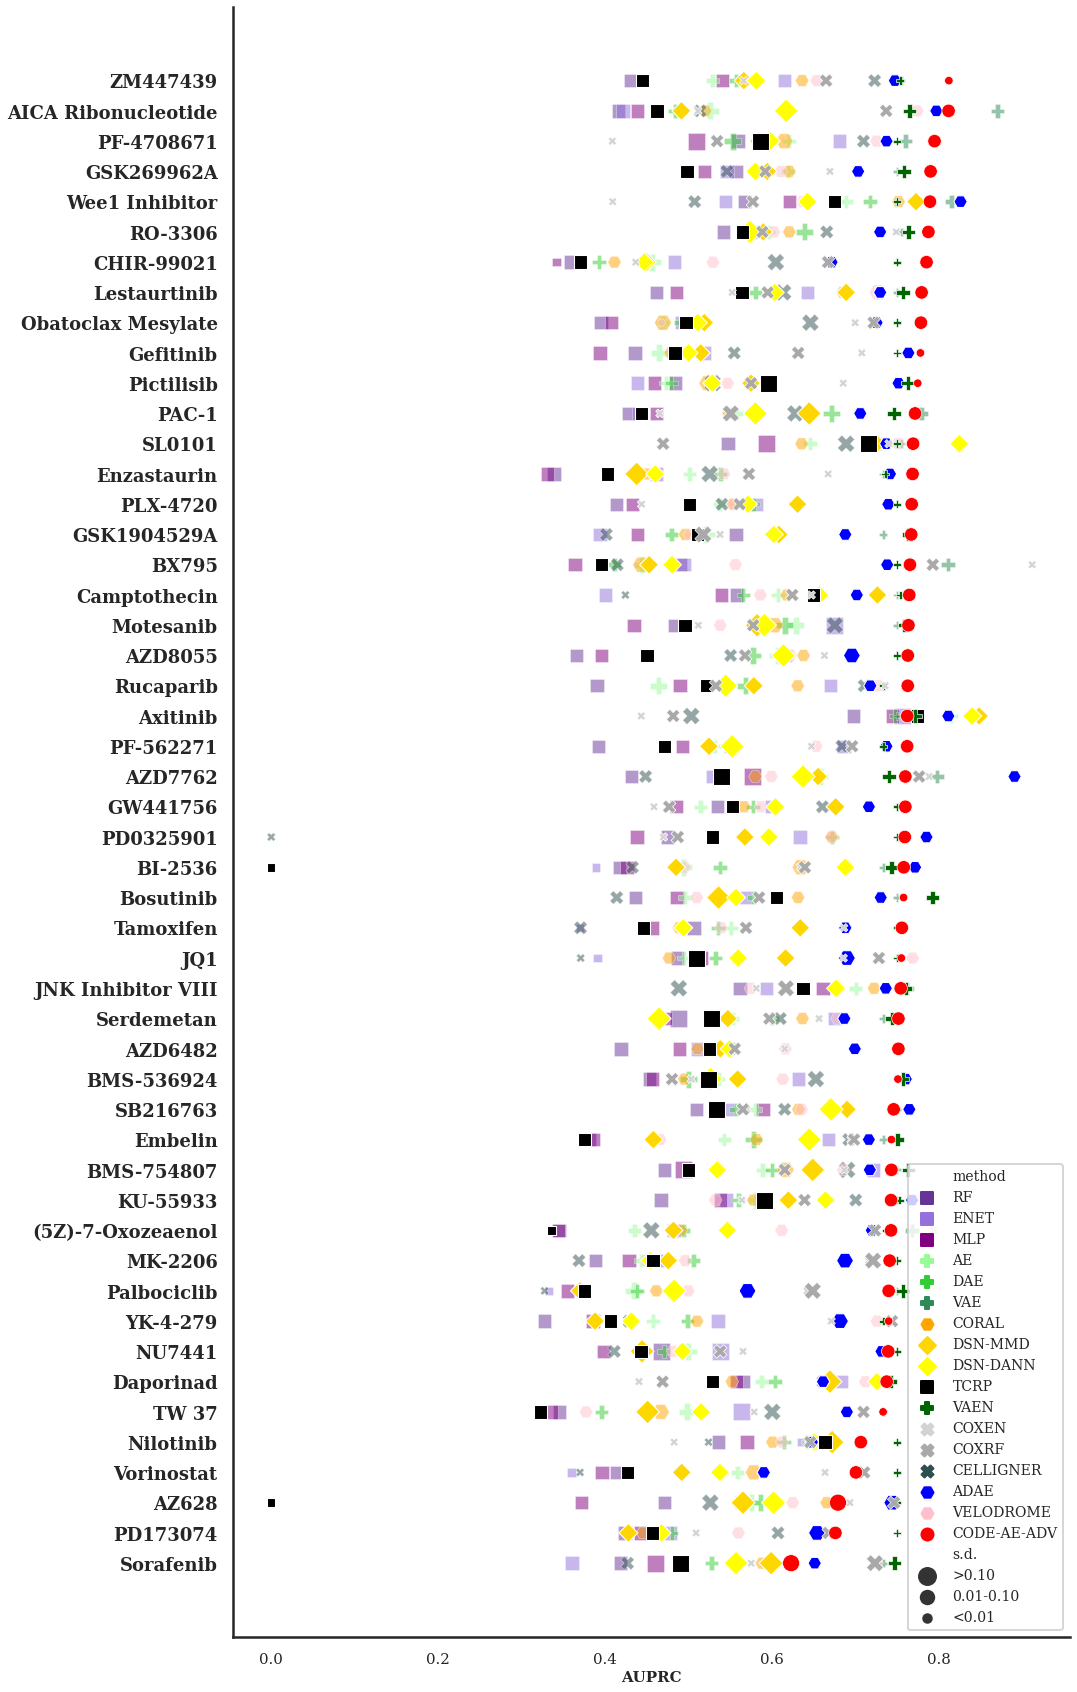

In [19]:
plt.figure(figsize=(15, 30))
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})
ax = sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                     alpha=0.5,
                     s=500,
                     palette=palette,
                     data=pdtc_plot_df[~pdtc_plot_df.method.isin(['CODE-AE-ADV', 'TCRP','VAEN','DSN-MMD','DSN-DANN','ADAE'])],
                    legend=True)
sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['DSN-MMD','DSN-DANN','ADAE'])],
                legend=False
               )

sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.', style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['TCRP'])],
                legend=False
               )
sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.', style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['VAEN', 'COXEN', 'COXRF'])],
                legend=False
               )

sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['CODE-AE-ADV'])],
                legend=False
               )


sns.despine()
plt.ylabel('')
plt.xlabel('AUPRC', fontsize=15, weight='bold')
plt.yticks(fontsize=18, weight='bold')
plt.xticks(fontsize=15)
plt.legend(loc='lower right', fontsize=14)
#plt.savefig('../paper/pdtc_auprc.png', format='png', dpi=350,bbox_inches='tight')

## Chemotherapy Drug Response Prediction

In [20]:
def get_largest_kv(d, std_dict):
    k = max(d.items(), key=itemgetter(1))[0]
    return k, d[k], std_dict[k]

def parse_param_str(param_str):
    pattern = re.compile('(pretrain_num_epochs)?_?(\d+)?_?(train_num_epochs)_(\d+)_(dop)_(\d\.\d)')
    matches = pattern.findall(param_str)
    return {matches[0][i]: float(matches[0][i+1]) for i in range(0,len(matches[0]), 2) if matches[0][i] != ''}

def parse_ft_evaluation_result(file_name, method, category, measurement='AUC',metric_name='auroc',pdtc_flag=False,folder='../intermediate_results/plot_data/tcga/model_save'):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc/{category}'
    else:
        folder = f'{folder}/{method}/{measurement}/{category}'        
    with open(os.path.join(folder, file_name), 'r') as f:
        result_dict = json.load(f)
    if 'enet' in result_dict:
        result_dict = result_dict['enet'][0]
    return result_dict[metric_name]

In [21]:
import re
from collections import Counter

def parse_hyper_ft_evaluation_result(method, category, measurement='AUC',metric_name='auroc', pdtc_flag = False, folder='../intermediate_results/plot_data/tcga/model_save'):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc/{category}'
    else:
        folder = f'{folder}/{method}/{measurement}/{category}'        
    evaluation_metrics = {}
    evaluation_metrics_std = {}
    evaluation_metrics_count = {}
    count = 0
    for file in os.listdir(folder):
        if re.match('(pretrain|train)+.*(dop+).*(ft)+.*\.json', file) or file == 'ft_evaluation_results.json':
            count += 1
            with open(os.path.join(folder, file), 'r') as f:
                result_dict = json.load(f)
            
            if 'enet' in result_dict:
                result_dict = result_dict['enet'][0]
            
            evaluation_metrics[file] = np.mean(result_dict[metric_name])
            evaluation_metrics_std[file] = np.std(result_dict[metric_name])
            evaluation_metrics_count[file] = len(Counter(result_dict[metric_name]))/len(result_dict[metric_name])
    to_exclude = []
    for k, v in evaluation_metrics_count.items():
        if v < 0.6: 
            to_exclude.append(k)
            
    if len(to_exclude)>0:
        for k in to_exclude:
            evaluation_metrics.pop(k)
            evaluation_metrics_std.pop(k)
                    
    return evaluation_metrics, evaluation_metrics_std, count
            

In [22]:
def generate_hyper_ft_report(metric_name='auroc', measurement='AUC', pdtc_flag=False, folder='../intermediate_results/plot_data/tcga/model_save'):
    methods = ['enet','rf','cell_enet','mlp','ae','dae', 'vae','vaen','coxen','coxrf','coral', 'adae','velodrome', 'tcrp','dsna','dsn','adsn_norm']
    if pdtc_flag:
        categories = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0).index.tolist()
    else:    
        categories = ['tgem', 'tfu','tem', 'gem', 'cis', 'sor', 'fu']

    #categories = ['female', 'male']
    
    report = pd.DataFrame(np.zeros((len(methods), len(categories))), index=methods, columns=categories)
    report_std = pd.DataFrame(np.zeros((len(methods), len(categories))), index=methods, columns=categories)
    result_dict = defaultdict(dict)

    for cat in categories:
        for method in methods:
            #print(f'{method}: {cat}')
            folder = f'{folder}/{method}'
            try:
                param_str, report.loc[method, cat], report_std.loc[method, cat] = get_largest_kv(d = parse_hyper_ft_evaluation_result(method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag)[0],
                                                                                                std_dict = parse_hyper_ft_evaluation_result(method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag)[1])
                if method in ['enet', 'rf', 'cell_enet']:
                    result_dict[cat][method] = parse_ft_evaluation_result(file_name = 'ft_evaluation_results.json', method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag)
                else:
                    result_dict[cat][method] = parse_ft_evaluation_result(file_name = param_str, 
                                                                          method=method, category=cat, 
                                                                          metric_name=metric_name, 
                                                                          measurement=measurement, 
                                                                          pdtc_flag=pdtc_flag)

            except Exception as e:
                print(e)

                
    return report, report_std, result_dict


In [23]:
auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_hyper_ft_report(metric_name='auroc', measurement='AUC')

max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence


In [24]:
#average rank when predict chemotherapy prediction on relapses after treatment
auc_ft_report[['tem','gem','cis','sor','fu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         13.8
rf           14.2
cell_enet    12.6
mlp          12.8
ae            6.4
dae           9.0
vae           9.2
vaen          6.2
coxen        10.6
coxrf        12.6
coral         7.4
adae          5.2
velodrome     7.2
tcrp         12.0
dsna          6.0
dsn           5.8
adsn_norm     1.6
dtype: float64

In [25]:
#average rank when predict chemotherapy prediction on clinical diagnosis
auc_ft_report[['tgem','tfu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         15.5
rf           14.5
cell_enet    14.0
mlp           6.5
ae            6.5
dae           3.0
vae          10.5
vaen         12.5
coxen        14.0
coxrf        16.5
coral         8.0
adae          4.5
velodrome     8.0
tcrp          9.0
dsna          5.0
dsn           4.0
adsn_norm     1.0
dtype: float64

In [26]:
#average rank when predict chemotherapy prediction overall
auc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)


enet         14.285714
rf           14.285714
cell_enet    13.000000
mlp          11.000000
ae            6.428571
dae           7.285714
vae           9.571429
vaen          8.000000
coxen        11.571429
coxrf        13.714286
coral         7.571429
adae          5.000000
velodrome     7.428571
tcrp         11.142857
dsna          5.714286
dsn           5.285714
adsn_norm     1.428571
dtype: float64

In [27]:
auc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)


enet         4.644505
rf           0.755929
cell_enet    4.582576
mlp          3.366502
ae           2.636737
dae          3.592320
vae          2.149197
vaen         4.690416
coxen        7.091242
coxrf        2.751623
coral        3.207135
adae         2.943920
velodrome    2.225395
tcrp         3.184785
dsna         1.799471
dsn          3.860669
adsn_norm    0.534522
dtype: float64

In [28]:
drug_mapping = pd.read_csv('../data/tcga_gdsc_drug_mapping.csv', index_col=0)

drug_dict = drug_mapping['gdsc_name'].to_dict()
drug_dict['tgem'] = 'Gemcitabine (diagnosis)'
drug_dict['tfu'] = '5-Fluorouracil (diagnosis)'

result_df = None
for cat in ['tgem', 'tfu', 'fu','tem', 'cis', 'sor', 'gem']:
    temp_df = pd.DataFrame.from_dict(auc_ft_result_dict[cat])
    temp_df = temp_df.rename(columns={'tcrp': 'TCRP', 'cell_enet':'CELLIGNER','dsn':"dsn-mmd", 'dsna': 'dsn-dann', 'adsn_norm': 'code-ae-adv'})
    temp_df = temp_df.rename(columns={k: k.upper() for k in temp_df.columns})

    temp_df = pd.melt(temp_df)
    temp_df['drug'] = drug_dict[cat]
    temp_df['metric'] = 'AUC'
    result_df = pd.concat((result_df, temp_df))
        
result_df = result_df.rename(columns={'variable': 'method', 'value': 'auroc'})
method_order = ['RF','ENET','MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN','COXRF','CELLIGNER','ADAE',"VELODROME", 'CODE-AE-ADV']
result_df.method = result_df.method.astype('category')
result_df.method.cat.set_categories(method_order, inplace=True)
result_df.sort_values(by='method', inplace=True)

drug_order = ['5-Fluorouracil (diagnosis)', '5-Fluorouracil', 'Temozolomide', 'Sorafenib','Gemcitabine (diagnosis)','Gemcitabine', 'Cisplatin']
result_df.drug = result_df.drug.astype('category')
result_df.drug.cat.set_categories(drug_order, inplace=True)
result_df.sort_values(by='drug', inplace=True)



<Figure size 1080x720 with 0 Axes>

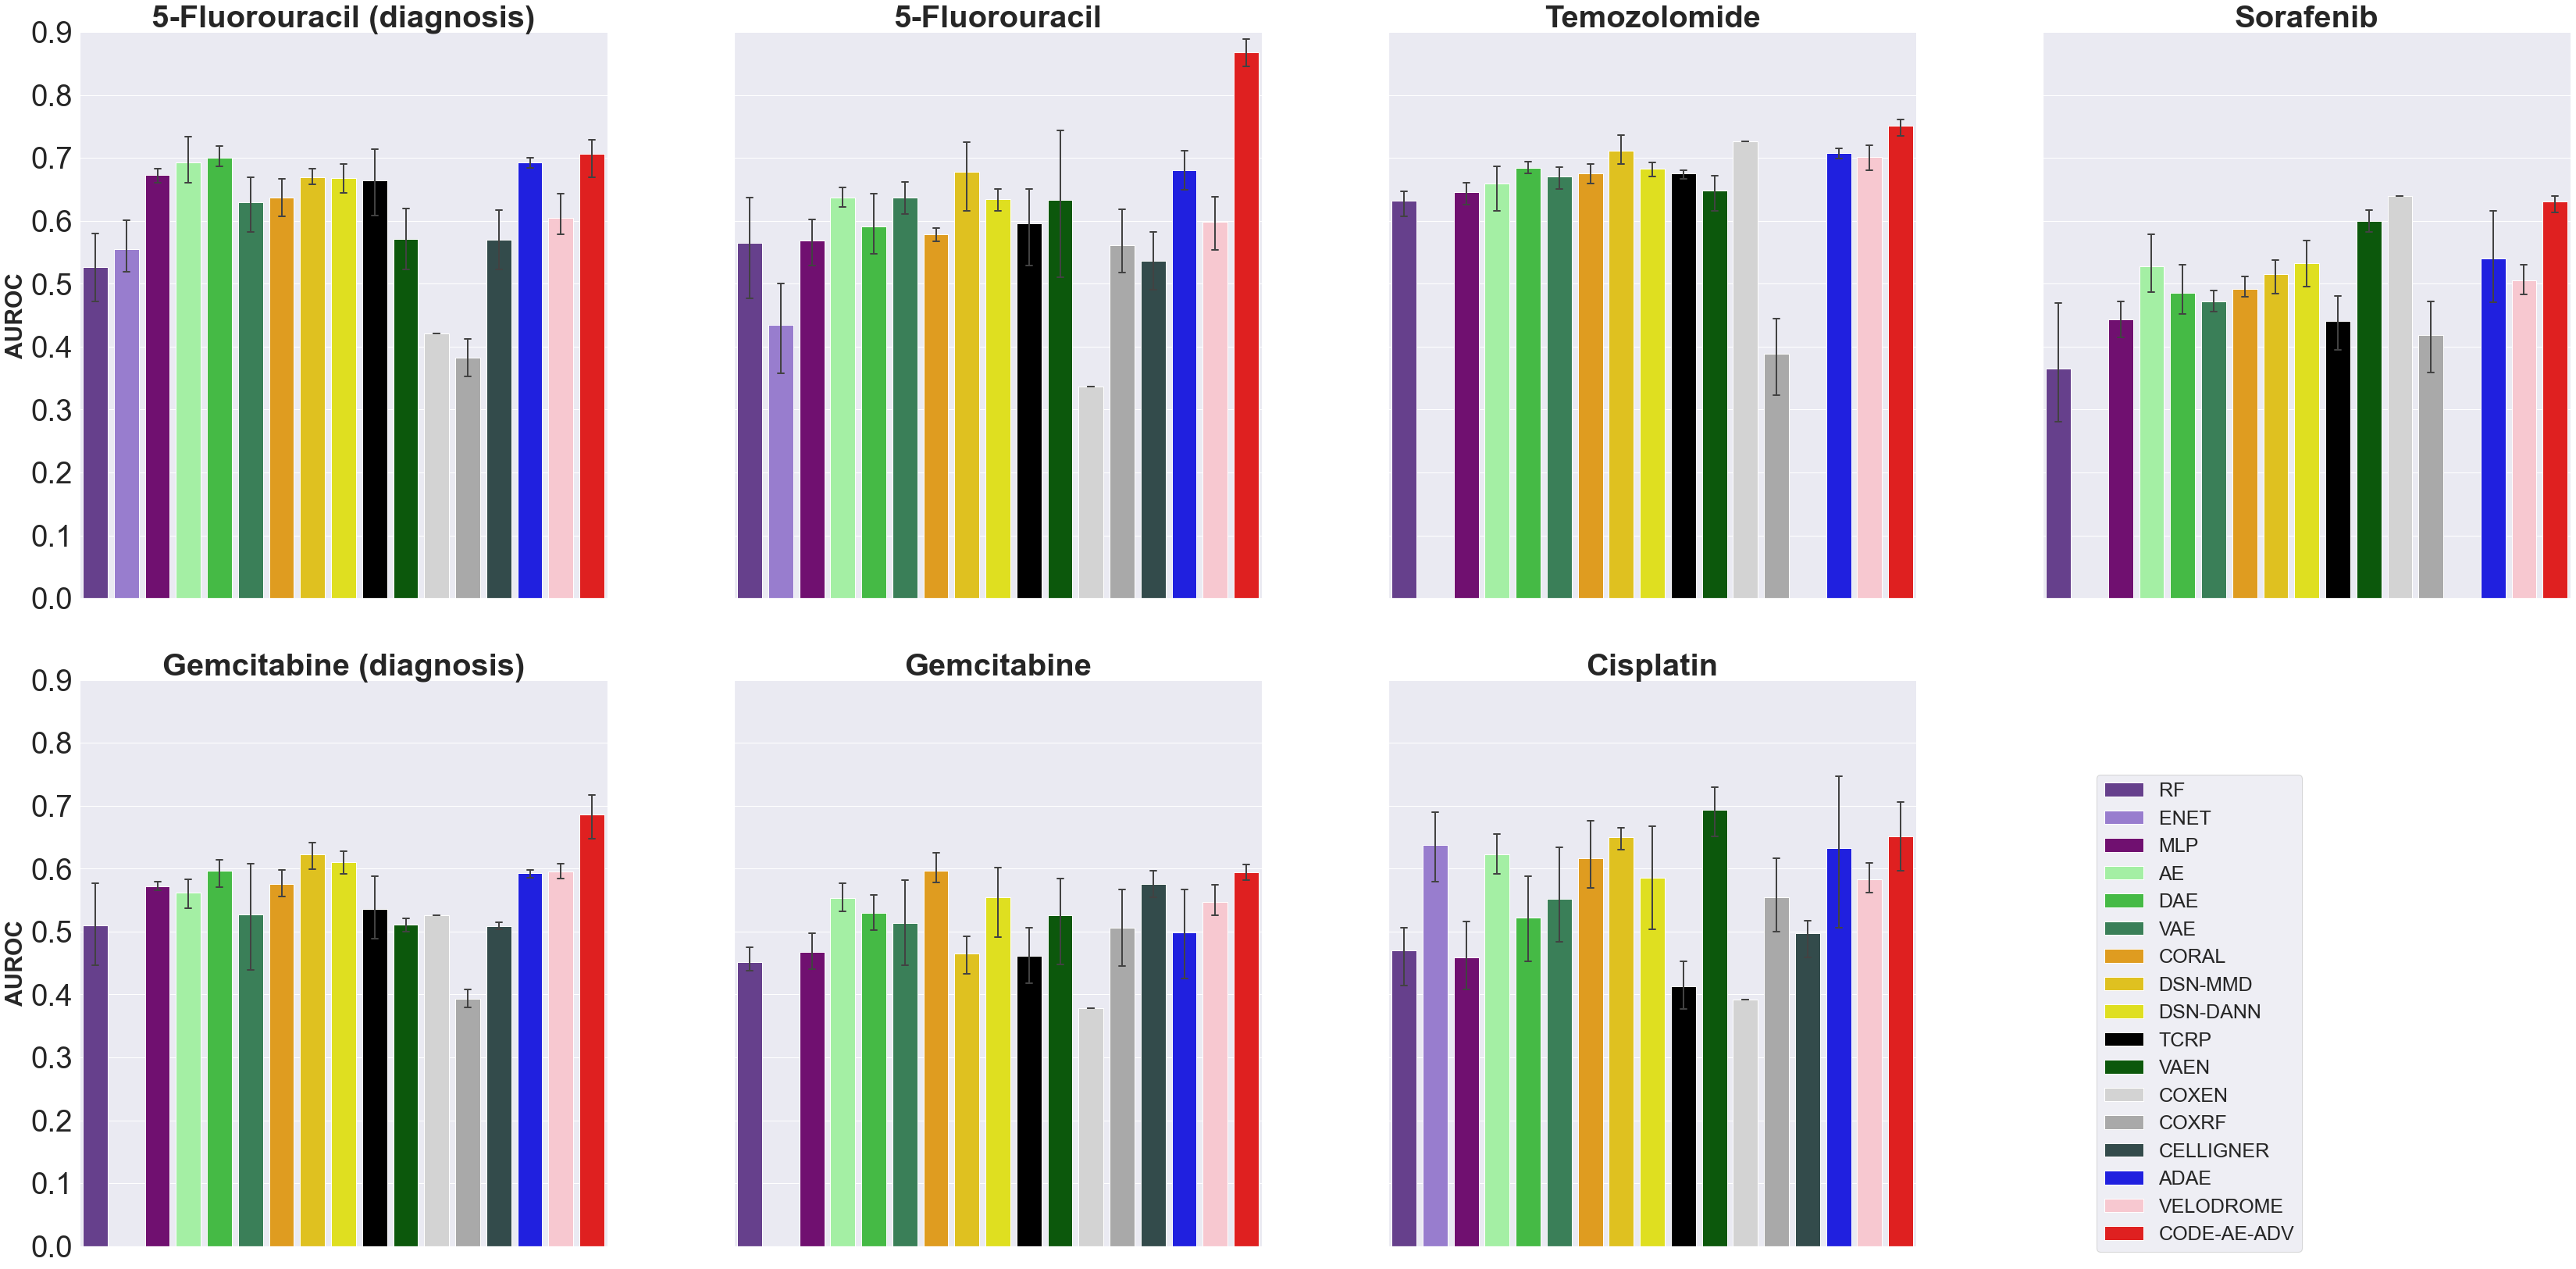

In [29]:
plt.figure(figsize=(15, 10))
sns.set(font_scale = 3.5)
g= sns.FacetGrid(result_df.loc[result_df.metric=='AUC'], col="drug", col_wrap=4, height=12)
g.map_dataframe(sns.barplot, x='method', y='auroc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=40, weight='bold')
g.set(ylim=(0.0,0.9))
g.set_xlabels('')
g.set_ylabels('AUROC', size=30, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(1.75, 0.85), fontsize=25)
#plt.savefig('../paper/tcga_auc_bar.png', format='png', dpi=350,bbox_inches='tight')

In [30]:
## check p vals
print('Gemcitabine (diagnosis): rank 1')
generate_p_val(a=auc_ft_result_dict['tgem']['adsn_norm'], b=auc_ft_result_dict['tgem']['dsn'])
print('5-Fluorouracil (diagnosis): rank 1')
generate_p_val(a=auc_ft_result_dict['tfu']['adsn_norm'], b=auc_ft_result_dict['tfu']['dae'])
print('5-Fluorouracil: rank 1')
generate_p_val(a=auc_ft_result_dict['fu']['adsn_norm'], b=auc_ft_result_dict['fu']['dsn'])
print('Temozolomide: rank 1')
generate_p_val(a=auc_ft_result_dict['tem']['adsn_norm'], b=auc_ft_result_dict['tem']['coxen'])
print('Sorafenib: rank 2')
generate_p_val(a=auc_ft_result_dict['sor']['adsn_norm'], b=auc_ft_result_dict['sor']['coxen'])
print('Gemcitabine: rank 2')
generate_p_val(a=auc_ft_result_dict['gem']['adsn_norm'], b=auc_ft_result_dict['gem']['coral'])
print('Cisplatin: rank 2')
generate_p_val(a=auc_ft_result_dict['cis']['adsn_norm'], b=auc_ft_result_dict['cis']['vaen'])

Gemcitabine (diagnosis): rank 1
ttest_ind:            t = 2.76614  p = 0.0289969
5-Fluorouracil (diagnosis): rank 1
ttest_ind:            t = 0.325404  p = 0.755977
5-Fluorouracil: rank 1
ttest_ind:            t = 5.28742  p = 0.00277022
Temozolomide: rank 1
ttest_ind:            t = 3.31203  p = 0.0295982
Sorafenib: rank 2
ttest_ind:            t = -1.0308  p = 0.360879
Gemcitabine: rank 2
ttest_ind:            t = -0.164713  p = 0.874624
Cisplatin: rank 2
ttest_ind:            t = -1.09289  p = 0.310245


### AUPRC

In [31]:
auprc_ft_report, auprc_ft_report_std, auprc_ft_result_dict = generate_hyper_ft_report(metric_name='auprc', measurement='AUPRC')

max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence


In [32]:
#average rank when predict chemotherapy prediction on relapses after treatment
auprc_ft_report[['tem','gem','cis','sor','fu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         13.8
rf           13.0
cell_enet    13.0
mlp          11.2
ae            9.4
dae           8.8
vae           7.6
vaen          6.4
coxen        10.8
coxrf        11.0
coral         6.6
adae          2.4
velodrome    10.8
tcrp         12.2
dsna          5.8
dsn           7.2
adsn_norm     1.6
dtype: float64

In [33]:
#average rank when predict chemotherapy prediction on clinical diagnosis
auprc_ft_report[['tgem','tfu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         15.0
rf           14.5
cell_enet     9.5
mlp          11.0
ae            7.5
dae           6.0
vae           5.5
vaen          4.5
coxen        10.5
coxrf        16.5
coral        11.0
adae          2.5
velodrome    10.5
tcrp         12.0
dsna          7.5
dsn           5.5
adsn_norm     2.5
dtype: float64

In [34]:
#average rank when predict chemotherapy prediction overall
auprc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)


enet         14.142857
rf           13.428571
cell_enet    12.000000
mlp          11.142857
ae            8.857143
dae           8.000000
vae           7.000000
vaen          5.857143
coxen        10.714286
coxrf        12.571429
coral         7.857143
adae          2.428571
velodrome    10.714286
tcrp         12.142857
dsna          6.285714
dsn           6.714286
adsn_norm     1.857143
dtype: float64

In [35]:
auprc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)


enet         4.259443
rf           2.070197
cell_enet    4.358899
mlp          2.544836
ae           3.023716
dae          3.265986
vae          3.785939
vaen         3.579040
coxen        5.964179
coxrf        3.735289
coral        3.023716
adae         1.272418
velodrome    5.964179
tcrp         2.544836
dsna         2.214670
dsn          3.988077
adsn_norm    1.214986
dtype: float64

In [36]:
result_df = None
for cat in ['tgem', 'tfu', 'fu','tem', 'cis', 'sor', 'gem']:
    temp_df = pd.DataFrame.from_dict(auprc_ft_result_dict[cat])
    temp_df = temp_df.rename(columns={'tcrp': 'TCRP','cell_enet':'CELLIGNER','dsn':"dsn-mmd", 'dsna': 'dsn-dann', 'adsn_norm': 'code-ae-adv'})
    temp_df = temp_df.rename(columns={k: k.upper() for k in temp_df.columns})

    temp_df = pd.melt(temp_df)
    temp_df['drug'] = drug_dict[cat]
    temp_df['metric'] = 'AUPRC'
    result_df = pd.concat((result_df, temp_df))
        
result_df = result_df.rename(columns={'variable': 'method', 'value': 'auprc'})
method_order = ['RF','ENET','MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN','COXRF','CELLIGNER','ADAE',"VELODROME", 'CODE-AE-ADV']
result_df.method = result_df.method.astype('category')
result_df.method.cat.set_categories(method_order, inplace=True)
result_df.sort_values(by='method', inplace=True)

drug_order = ['5-Fluorouracil (diagnosis)', '5-Fluorouracil', 'Temozolomide', 'Sorafenib','Gemcitabine (diagnosis)','Gemcitabine', 'Cisplatin']
result_df.drug = result_df.drug.astype('category')
result_df.drug.cat.set_categories(drug_order, inplace=True)
result_df.sort_values(by='drug', inplace=True)

<Figure size 1080x720 with 0 Axes>

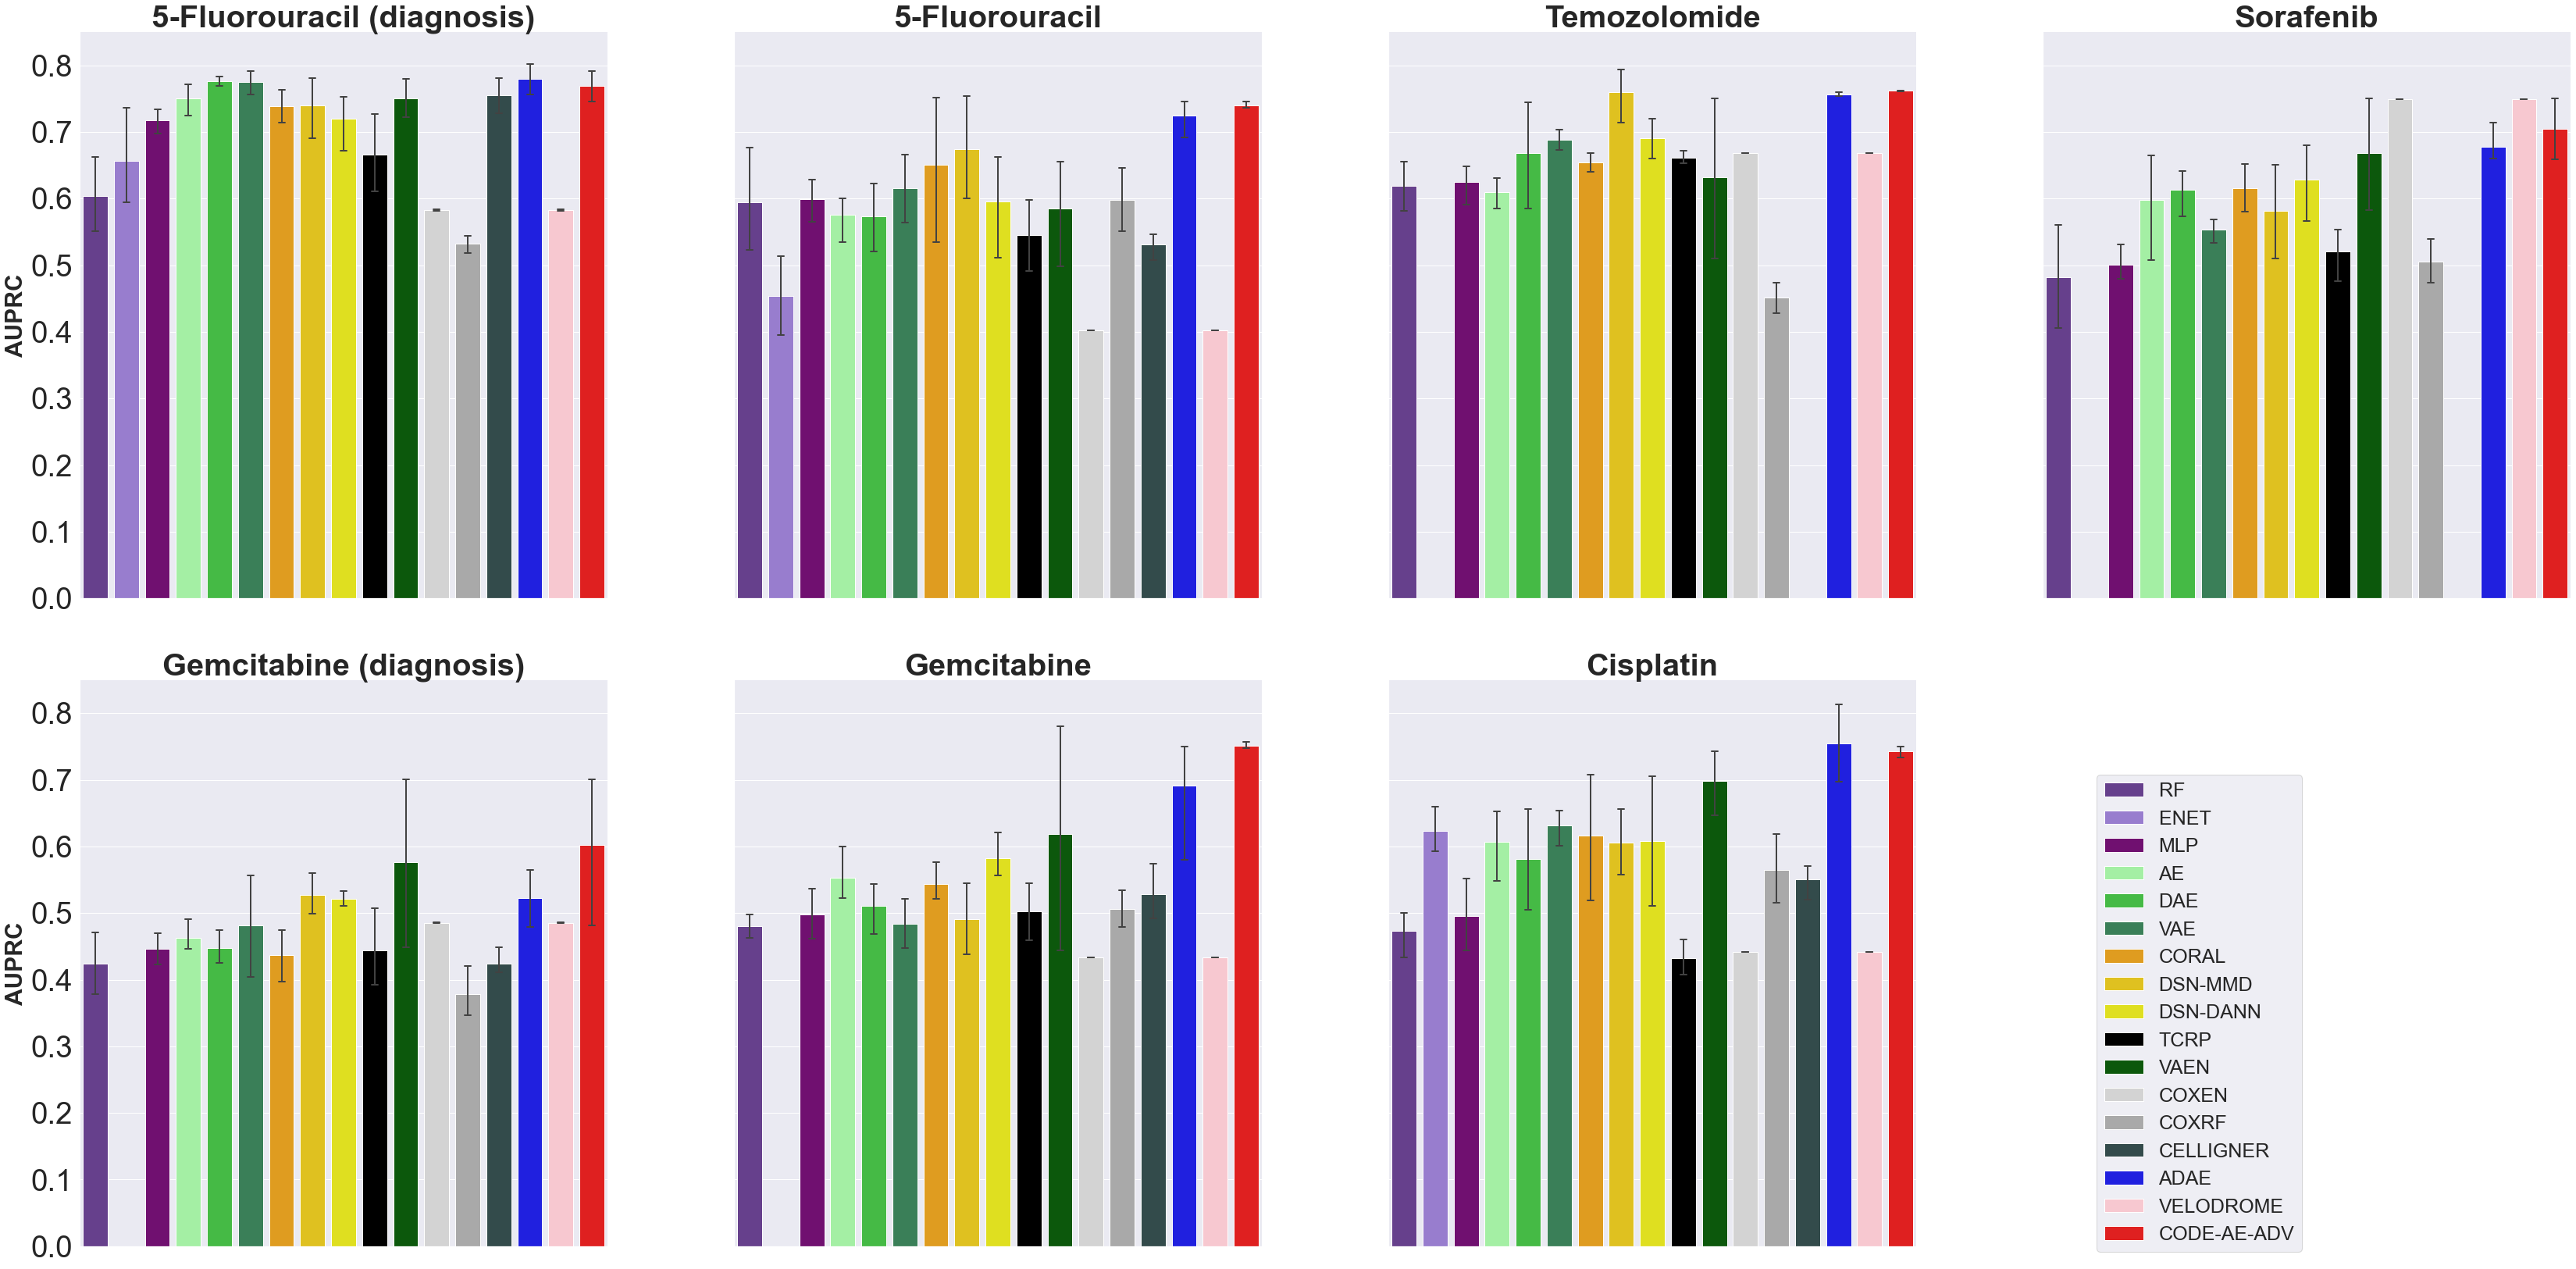

In [37]:
plt.figure(figsize=(15, 10))
sns.set(font_scale = 3.5)
g= sns.FacetGrid(result_df.loc[result_df.metric=='AUPRC'], col="drug", col_wrap=4, height=12)
g.map_dataframe(sns.barplot, x='method', y='auprc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=40, weight='bold')
g.set(ylim=(0.0,0.85))
g.set_xlabels('')
g.set_ylabels('AUPRC', size=30, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(1.75, 0.85), fontsize=25)
#plt.savefig('../paper/tcga_auprc_bar.png', format='png', dpi=350,bbox_inches='tight')

In [39]:
## check p vals
print('Gemcitabine (diagnosis): rank 1')
generate_p_val(a=auc_ft_result_dict['tgem']['adsn_norm'], b=auc_ft_result_dict['tgem']['vaen'])
print('5-Fluorouracil (diagnosis): rank 2')
generate_p_val(a=auc_ft_result_dict['tfu']['adsn_norm'], b=auc_ft_result_dict['tfu']['adae'])
print('5-Fluorouracil: rank 1')
generate_p_val(a=auc_ft_result_dict['fu']['adsn_norm'], b=auc_ft_result_dict['fu']['adae'])
print('Temozolomide: rank 1')
generate_p_val(a=auc_ft_result_dict['tem']['adsn_norm'], b=auc_ft_result_dict['tem']['adae'])
print('Sorafenib: rank 3')
generate_p_val(a=auc_ft_result_dict['sor']['adsn_norm'], b=auc_ft_result_dict['sor']['velodrome'])
print('Gemcitabine: rank 1')
generate_p_val(a=auc_ft_result_dict['gem']['adsn_norm'], b=auc_ft_result_dict['gem']['adae'])
print('Cisplatin: rank 2')
generate_p_val(a=auc_ft_result_dict['cis']['adsn_norm'], b=auc_ft_result_dict['cis']['adae'])

Gemcitabine (diagnosis): rank 1
ttest_ind:            t = 8.57459  p = 0.000379119
5-Fluorouracil (diagnosis): rank 2
ttest_ind:            t = 0.699231  p = 0.518632
5-Fluorouracil: rank 1
ttest_ind:            t = 8.42216  p = 4.69713e-05
Temozolomide: rank 1
ttest_ind:            t = 4.94461  p = 0.0020183
Sorafenib: rank 3
ttest_ind:            t = 8.09469  p = 0.000101699
Gemcitabine: rank 1
ttest_ind:            t = 2.27469  p = 0.0817732
Cisplatin: rank 2
ttest_ind:            t = 0.237033  p = 0.82131


### tSNE plots for difference features

In [192]:
tsne = manifold.TSNE(n_components=2, init='random',random_state=0)


In [201]:
ori_gex = pd.read_csv('../data/preprocessed_dat/uq1000_feature.csv', index_col=0)
gex_label = ['TCGA'] * 9808 + ['CCLE']*1305


In [202]:
ori_gex_y = tsne.fit_transform(ori_gex)

In [205]:
ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
ori_encoder_feature_df['Sample'] = gex_label

Text(0.5, 1.0, 'Original')

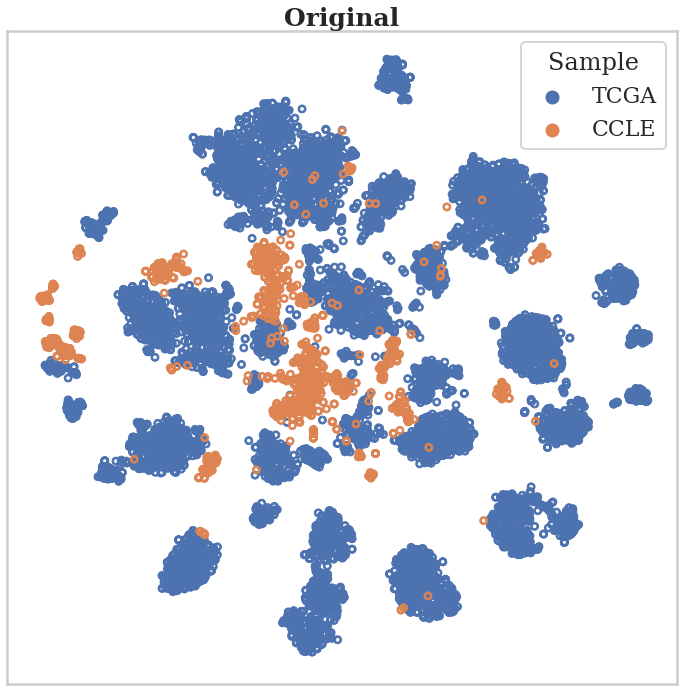

In [208]:
plt.figure(figsize=(12,12))
sns.set(font_scale = 2.0)
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


ax = sns.scatterplot(x='x',y='y',data=ori_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('Original', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/Original_tSNE.png', format='png', dpi=350,bbox_inches='tight')


In [209]:
ccle_gex = pd.read_csv(f'../intermediate_results/encoded_features/ae_ccle_features.csv',index_col=0)
tcga_gex = pd.read_csv(f'../intermediate_results/encoded_features/ae_tcga_features.csv',index_col=0)
ae_all_gex = pd.concat([tcga_gex, ccle_gex])
ae_all_gex_y = tsne.fit_transform(ae_all_gex)


    

Text(0.5, 1.0, 'AE')

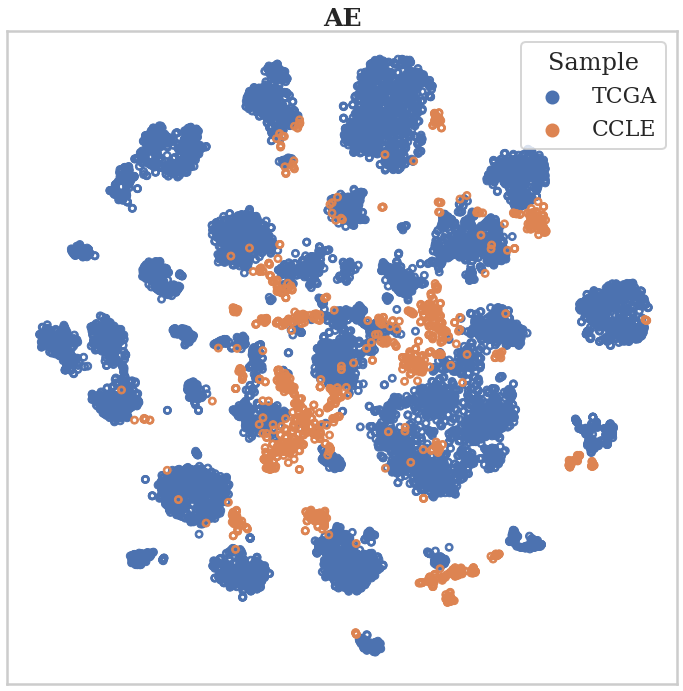

In [211]:
ae_encoder_feature_df = pd.DataFrame(ae_all_gex_y, columns=['x','y'])
ae_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

ax = sns.scatterplot(x='x',y='y',data=ae_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('AE', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/AE_tSNE.png', format='png', dpi=350,bbox_inches='tight')


In [212]:
ccle_gex = pd.read_csv(f'../intermediate_results/encoded_features/codeae_ccle_features.csv',index_col=0)
tcga_gex = pd.read_csv(f'../intermediate_results/encoded_features/codeae_tcga_features.csv',index_col=0)
codeae_all_gex = pd.concat([tcga_gex, ccle_gex])
codeae_all_gex_y = tsne.fit_transform(codeae_all_gex)


    

Text(0.5, 1.0, 'AE')

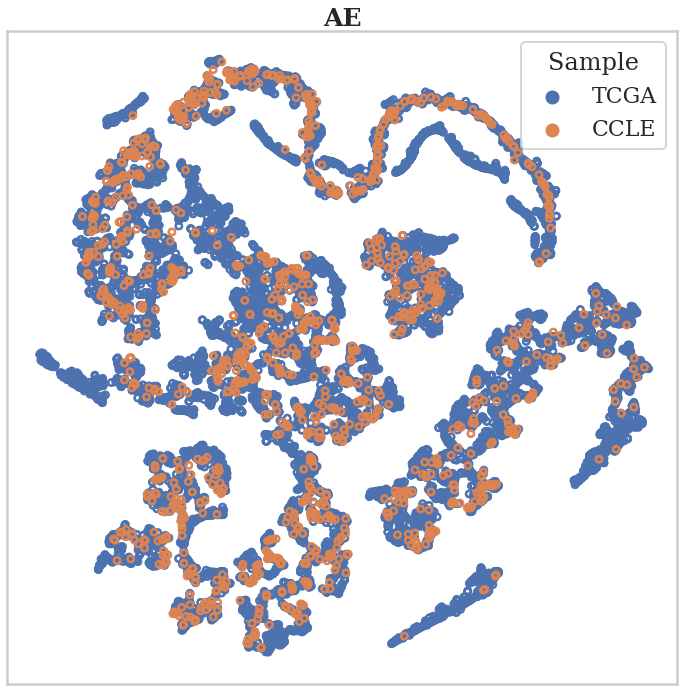

In [213]:
codeae_encoder_feature_df = pd.DataFrame(codeae_all_gex_y, columns=['x','y'])
codeae_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

ax = sns.scatterplot(x='x',y='y',data=codeae_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('AE', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/CODEAE_tSNE.png', format='png', dpi=350,bbox_inches='tight')
